In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from game import MiningInSpaceGame
from agents import RandomAgent, MeanTrackingAgent, LinearUCBAgent, LinearThompsonAgent, GPUCBAgent, GPThompsonAgent
from simulation import run_batch_simulation

In [2]:
agents_to_test = {
    "Random": RandomAgent,
    "MeanTracker": MeanTrackingAgent,
    "Linear-UCB": LinearUCBAgent,
    "Linear-UCB-No-Pseudo": lambda: LinearUCBAgent(pseudo_observations=False),
    "Linear-Thompson": LinearThompsonAgent,
    "Linear-Thompson-No-Pseudo": lambda: LinearThompsonAgent(pseudo_observations=False),
    "Gaussian-UCB": GPUCBAgent,
    "Gaussian-Thompson": GPThompsonAgent
}

In [3]:
df_results = run_batch_simulation(agents_to_test, MiningInSpaceGame, n_simulations=30, n_trials=150)

Simulating Agent: Random (30 runs)...
Simulating Agent: MeanTracker (30 runs)...
Simulating Agent: Linear-UCB (30 runs)...
Simulating Agent: Linear-UCB-No-Pseudo (30 runs)...
Simulating Agent: Linear-Thompson (30 runs)...
Simulating Agent: Linear-Thompson-No-Pseudo (30 runs)...
Simulating Agent: Gaussian-UCB (30 runs)...
Simulating Agent: Gaussian-Thompson (30 runs)...


In [4]:
df_results

,agent,trial,choice,reward,mu_0,sigma_0,lower_0,upper_0,mu_1,sigma_1,...,mu_2,sigma_2,lower_2,upper_2,mu_3,sigma_3,lower_3,upper_3,simulation_id,agent_name
0,RandomAgent,1,1,77.674532,50.000000,NaN,NaN,NaN,50.000000,NaN,...,50.000000,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0,Random
1,RandomAgent,2,3,56.075409,50.000000,NaN,NaN,NaN,50.000000,NaN,...,50.000000,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0,Random
2,RandomAgent,3,0,47.980888,50.000000,NaN,NaN,NaN,50.000000,NaN,...,50.000000,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0,Random
3,RandomAgent,4,3,53.061913,50.000000,NaN,NaN,NaN,50.000000,NaN,...,50.000000,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0,Random
4,RandomAgent,5,2,88.022820,50.000000,NaN,NaN,NaN,50.000000,NaN,...,50.000000,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0,Random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,GPThompsonAgent,146,0,82.813471,81.245518,1.064410,79.159274,83.331762,51.765969,3.478651,...,29.209306,4.842951,19.717122,38.701490,42.495677,2.855540,36.898819,48.092534,29,Gaussian-Thompson
35996,GPThompsonAgent,147,2,76.781476,47.509474,2.855578,41.912541,53.106408,54.166451,2.855570,...,78.581904,1.019221,76.584231,80.579576,53.404654,4.842960,43.912452,62.896856,29,Gaussian-Thompson
35997,GPThompsonAgent,148,1,79.076272,54.010172,1.660701,50.755198,57.265145,77.532750,1.288166,...,43.493099,4.843028,34.000764,52.985434,40.521968,3.478699,33.703718,47.340218,29,Gaussian-Thompson
35998,GPThompsonAgent,149,2,76.470858,47.116912,4.845572,37.619590,56.614233,57.835438,4.842838,...,81.041014,1.041081,79.000496,83.081533,48.845038,4.843111,39.352540,58.337536,29,Gaussian-Thompson


In [5]:
df_results.to_clipboard()

In [6]:
df_results.to_csv("simulation_results.csv", index=False)

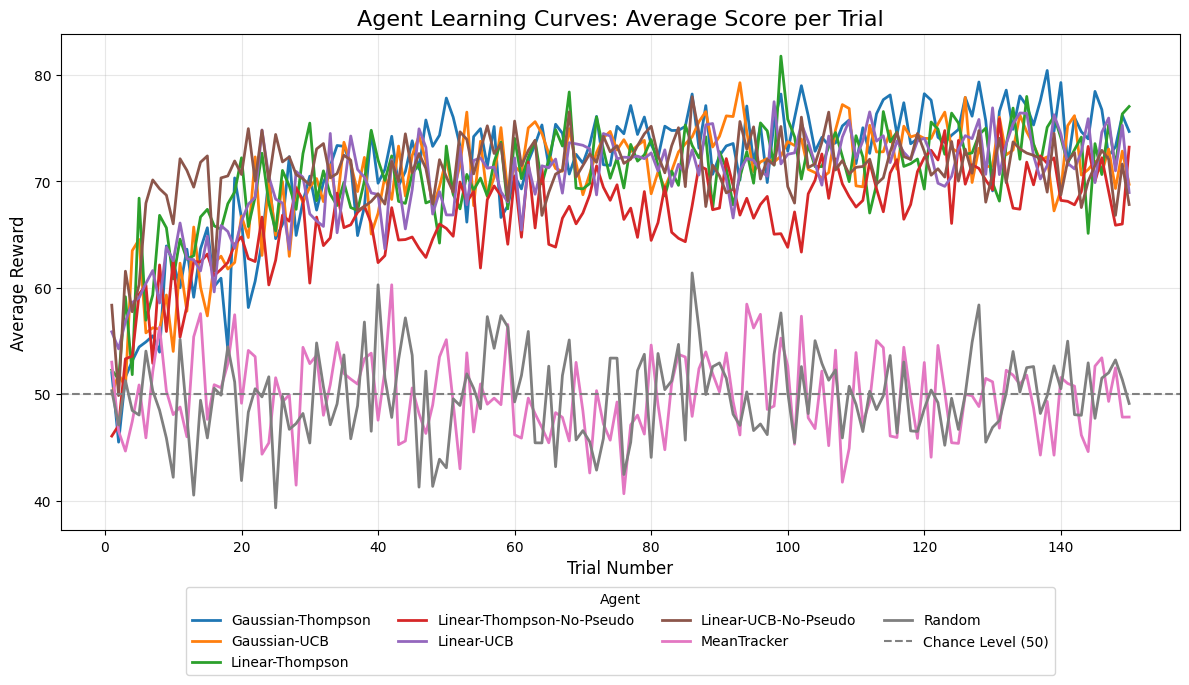

In [7]:
learning_curves = df_results.groupby(['agent_name', 'trial'])['reward'].mean().reset_index()

# ---------------------------------------------------------
# Graph 1: Combined Learning Curves (Averages Only)
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=learning_curves, 
    x='trial', 
    y='reward', 
    hue='agent_name',
    linewidth=2
)

plt.axhline(y=50, color='gray', linestyle='--', label='Chance Level (50)')
plt.title('Agent Learning Curves: Average Score per Trial', fontsize=16)
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(title='Agent', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('learning_curves.pdf')
plt.show()

In [ ]:
def plot_single_simulation_uncertainty(data, simulation_id, agent_name):
    """
    Plots the trajectory of uncertainty for all 4 arms for a single simulation.
    
    Args:
        data (pd.DataFrame): The full_data dataframe.
        simulation_id (int): The specific ID to visualize.
        agent_name (str): The name of the agent (e.g., 'LinearUCBAgent').
    """
    # Filter for the specific run
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)]
    
    if subset.empty:
        print("No data found for this selection.")
        return

    plt.figure(figsize=(10, 6))
    
    # Plot each arm's sigma
    # We assume columns are named sigma_0, sigma_1, etc.
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Standard discrete colors
    
    for i in range(4):
        plt.plot(subset['trial'], subset[f'sigma_{i}'], 
                 label=f'Arm {i}', color=colors[i], linewidth=2)
    
    plt.title(f"Uncertainty per Arm - Sim {simulation_id} ({agent_name})")
    plt.xlabel("Trial")
    plt.ylabel("Uncertainty ($\sigma$)")
    plt.legend(title="Arms")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_aggregated_uncertainty(data, agent_name):
    """
    Plots the average uncertainty with 95% Confidence Intervals 
    for a specific agent class across all simulations.
    """
    # Filter for the agent
    subset = data[data['agent_name'] == agent_name].copy()
    
    if subset.empty:
        print(f"No data found for Agent {agent_name}")
        return
        
    # Transform Data for Seaborn:
    # We turn columns [sigma_0, sigma_1...] into rows [Arm: 'sigma_0', Value: 1.2]
    melted = subset.melt(
        id_vars=['trial', 'simulation_id'], 
        value_vars=['sigma_0', 'sigma_1', 'sigma_2', 'sigma_3'],
        var_name='Arm', 
        value_name='Uncertainty'
    )
    
    # Clean up the names for the legend (optional)
    melted['Arm'] = melted['Arm'].str.replace('sigma_', 'Arm ')

    plt.figure(figsize=(10, 6))
    
    # Plot
    sns.lineplot(
        data=melted,
        x='trial',
        y='Uncertainty',
        hue='Arm',
        errorbar=('ci', 95),  # Shows 95% Confidence Interval
        palette='tab10'
    )
    
    plt.title(f"Average Uncertainty Reduction - {agent_name} (n={subset['simulation_id'].nunique()})")
    plt.xlabel("Trial")
    plt.ylabel("Perceived Uncertainty ($\sigma$)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

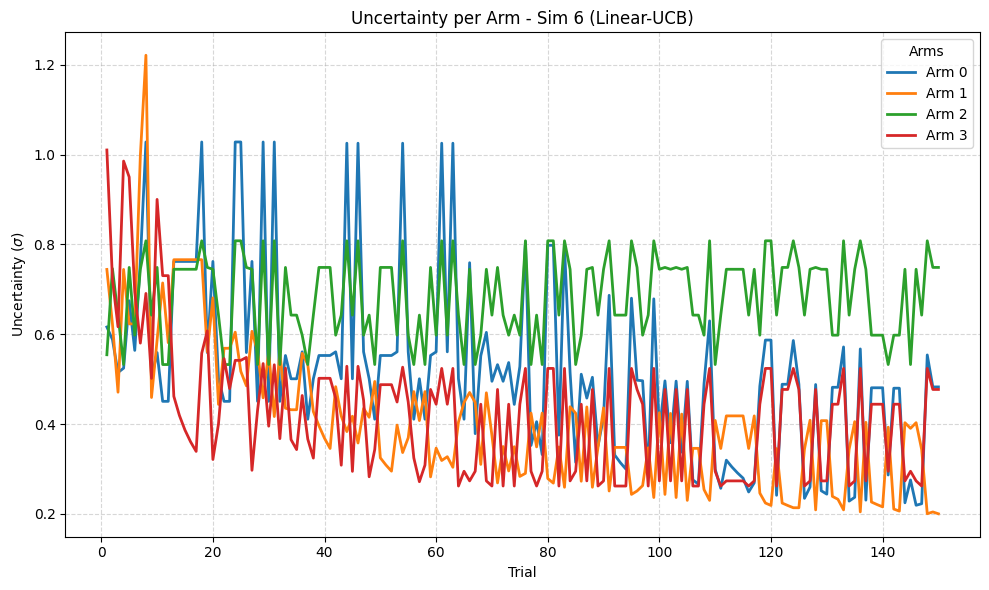

In [9]:
plot_single_simulation_uncertainty(df_results, simulation_id=6, agent_name="Linear-UCB")

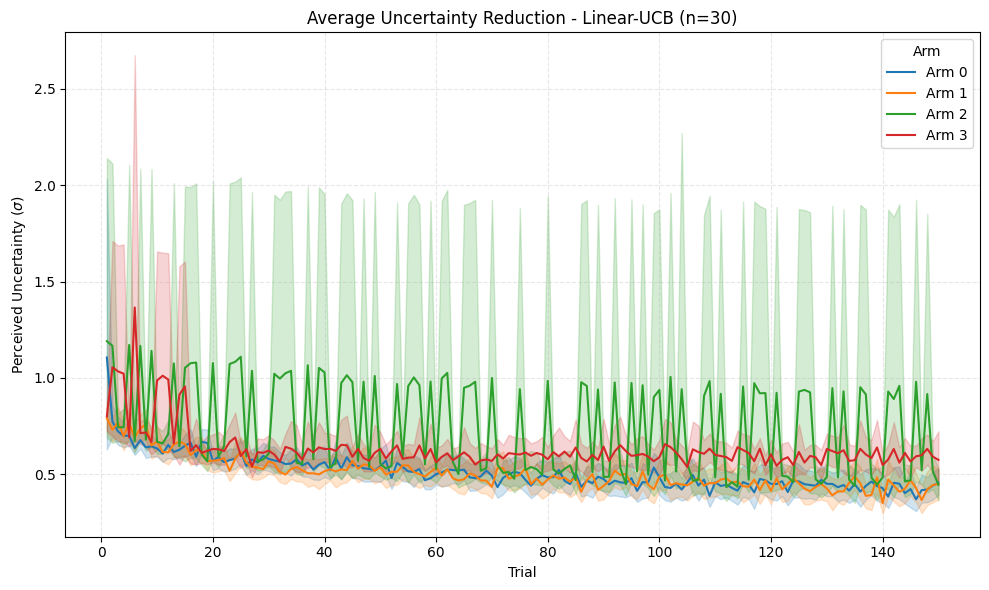

In [11]:
plot_aggregated_uncertainty(df_results, agent_name="Linear-UCB")

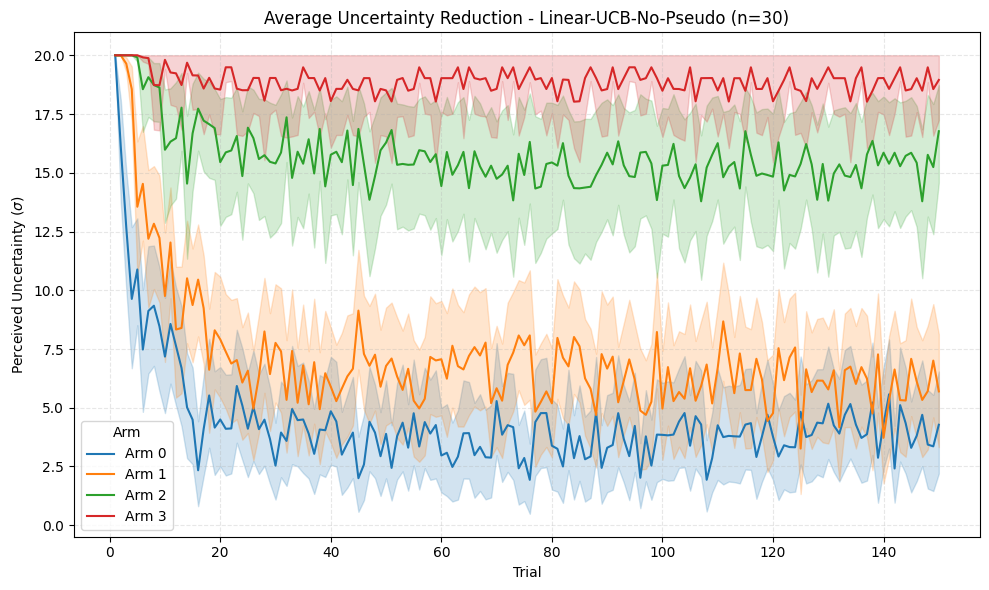

In [12]:
plot_aggregated_uncertainty(df_results, agent_name="Linear-UCB-No-Pseudo")

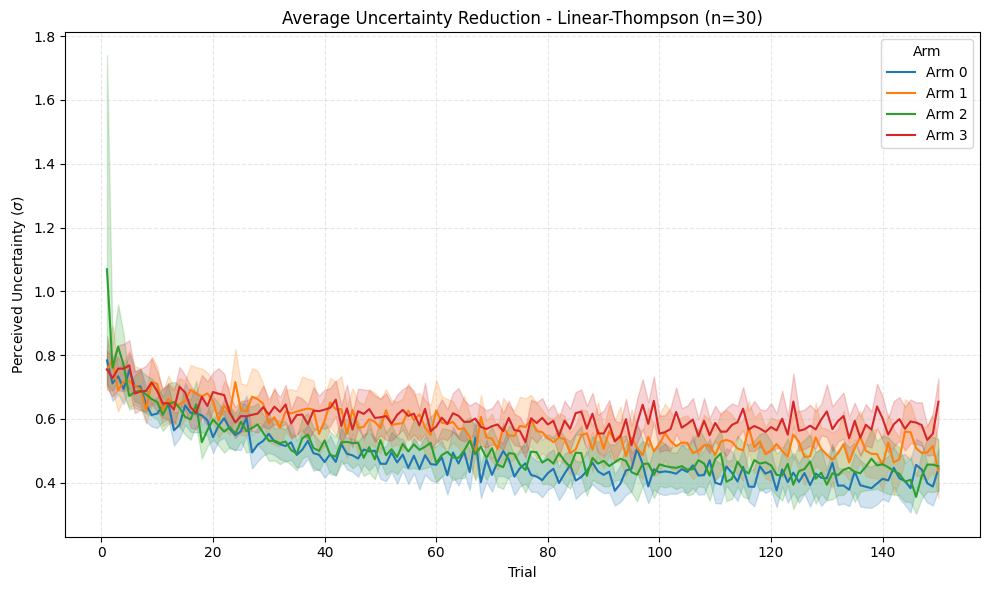

In [13]:
plot_aggregated_uncertainty(df_results, agent_name="Linear-Thompson")

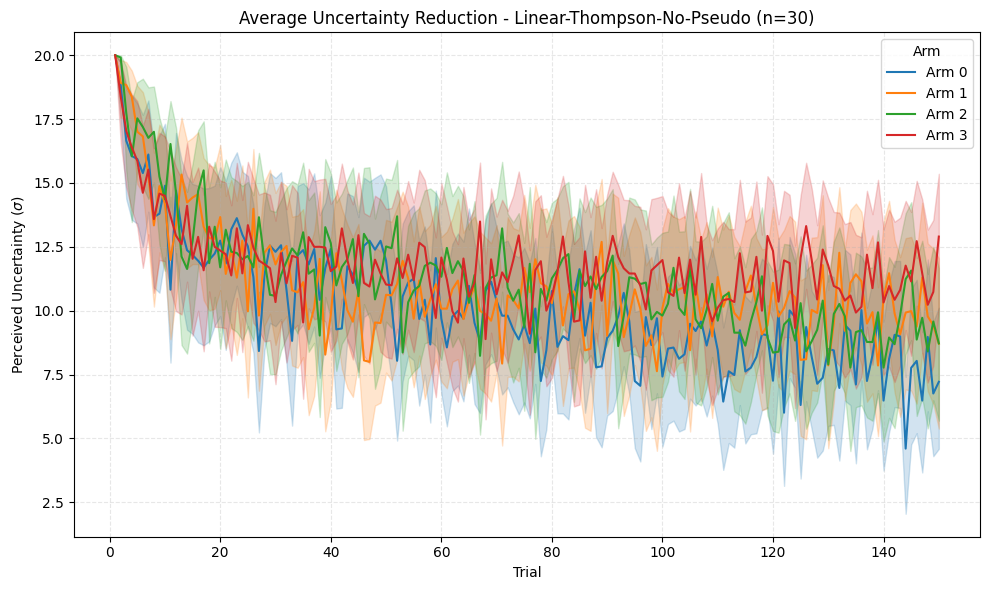

In [14]:
plot_aggregated_uncertainty(df_results, agent_name="Linear-Thompson-No-Pseudo")

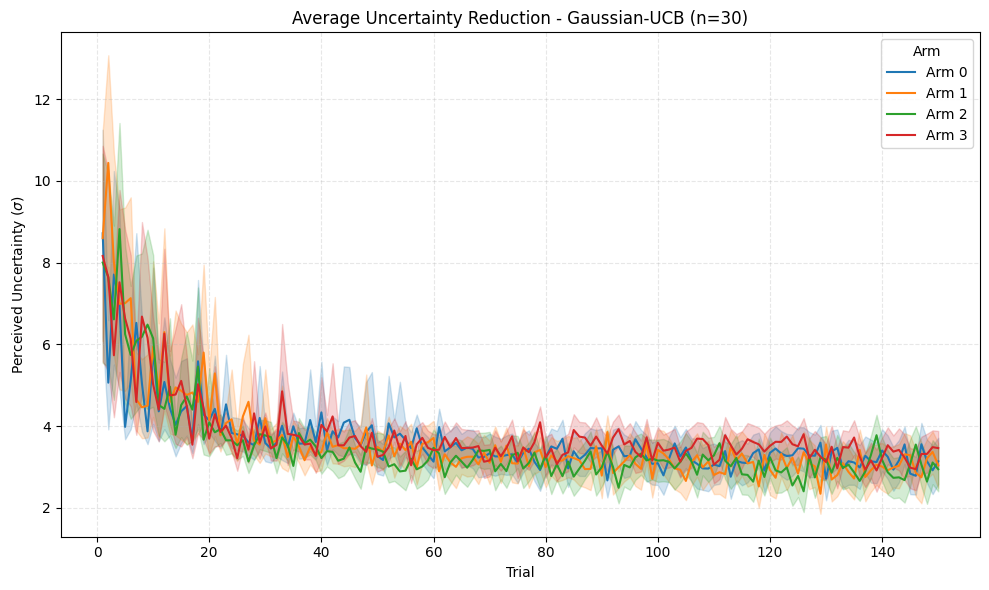

In [15]:
plot_aggregated_uncertainty(df_results, agent_name="Gaussian-UCB")

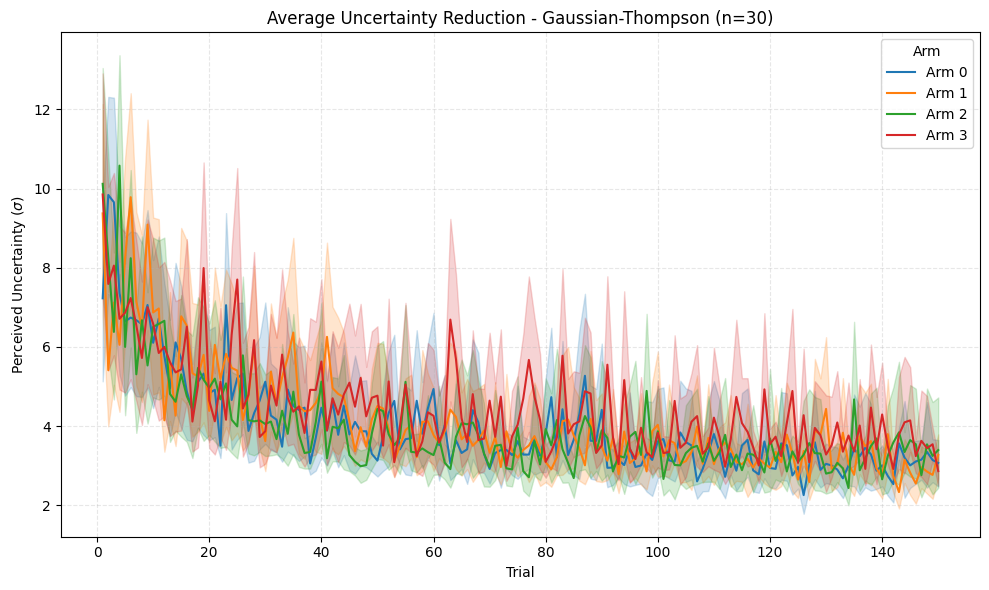

In [16]:
plot_aggregated_uncertainty(df_results, agent_name="Gaussian-Thompson")

In [46]:
def plot_single_sim_width(data, simulation_id, agent_name):
    """
    Plots the width of the confidence interval (Upper - Lower) for a single run.
    """
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)].copy()
    
    if subset.empty:
        print("No data found.")
        return

    plt.figure(figsize=(10, 6))
    
    # Calculate and Plot Widths for all 4 arms
    for i in range(4):
        # The key calculation:
        width = subset[f'upper_{i}'] - subset[f'lower_{i}']
        
        plt.plot(subset['trial'], width, label=f'Arm {i}', linewidth=2)
        
    plt.title(f"Interval Width Evolution - Sim {simulation_id} ({agent_name})")
    plt.xlabel("Trial")
    plt.ylabel("Width of Interval (Points)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_avg_width(data, agent_name):
    """
    Plots the average interval width across all simulations.
    """
    subset = data[data['agent_name'] == agent_name].copy()
    
    # 1. Calculate Widths for every row first
    # We add temporary columns to the dataframe
    for i in range(4):
        subset[f'Width Arm {i}'] = subset[f'upper_{i}'] - subset[f'lower_{i}']
    
    # 2. Melt for Seaborn
    # We only keep the new 'Width' columns
    melted = subset.melt(
        id_vars=['trial', 'simulation_id'],
        value_vars=[f'Width Arm {i}' for i in range(4)],
        var_name='Arm',
        value_name='Interval Width'
    )
    
    # Clean string "Width Arm 0" -> "Arm 0" if desired, but "Width Arm 0" is clear.
    
    plt.figure(figsize=(10, 6))
    
    # 3. Plot
    sns.lineplot(
        data=melted,
        x='trial',
        y='Interval Width',
        hue='Arm',
        errorbar=('ci', 95)
    )
    
    plt.title(f"Average Interval Width - {agent_name}")
    plt.xlabel("Trial")
    plt.ylabel("Average Width of Interval (Points)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

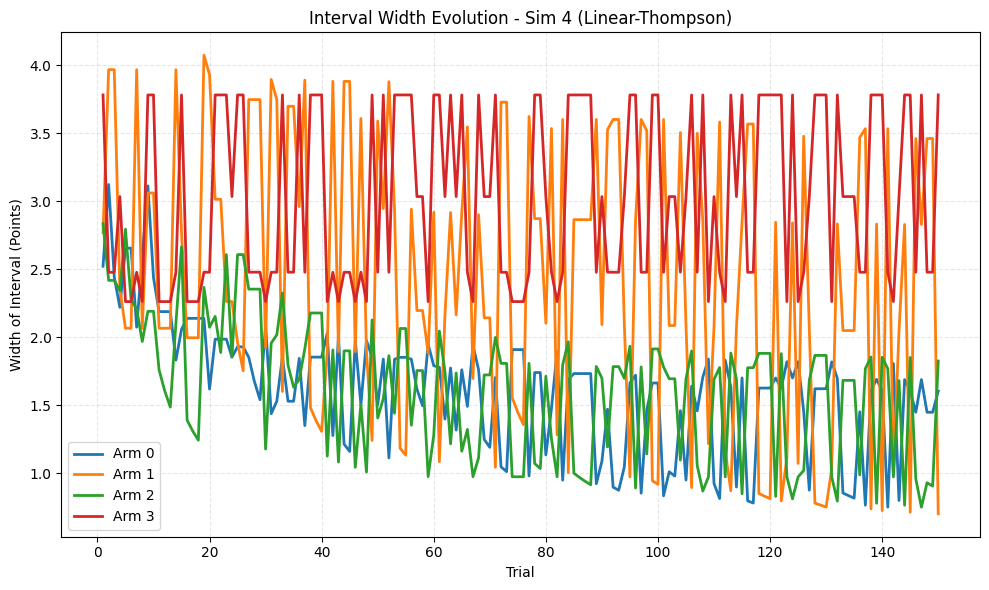

In [58]:
plot_single_sim_width(df_results, simulation_id=4, agent_name="Linear-Thompson")

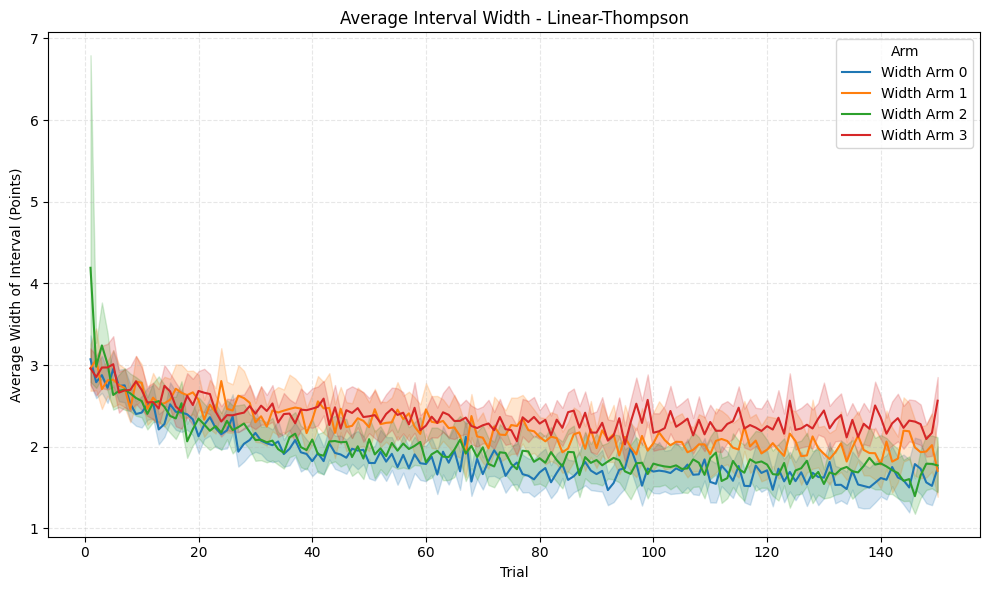

In [54]:
plot_avg_width(df_results, agent_name="Linear-Thompson")